Making sure the current working directory is correctly set

In [10]:
import os
from pathlib import Path

# Get the current working directory
cwd = Path.cwd()
print("Current working directory:", cwd)

# Define the explicit path to the project root ('concrete-crack-detection') relative to cwd
project_root = 'concrete-crack-detection'

# Check if the current working directory is already the project root
if cwd.name != project_root:
    # Change the working directory to the project root
    os.chdir('..')
    print("Changed working directory to project root:", Path.cwd())
else:
    print("Already in the project root directory.")


Current working directory: c:\Users\youne\OneDrive\Desktop\github-repos\concrete-crack-detection
Already in the project root directory.


-------------------------

Loading features and target

In [11]:
import numpy as np

# Loading Feature X and target y:
X = np.load('data//processed//feature_X.npy')
y = np.load('data//processed//target_y.npy')

# Information on the data:
print(f"X shape: {X.shape}. Memory: {X.nbytes / 1024**2:.2f} MB.")
print(f"y shape: {y.shape}. Memory: {y.nbytes / 1024**2:.2f} MB.")

X shape: (5000, 227, 227, 3). Memory: 737.13 MB.
y shape: (5000,). Memory: 0.00 MB.


Splitting dataset into train, test and validation set

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and testing sets:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Information on the data:
print(f"X_train shape: {X_train.shape}.")
print(f"X_val shape: {X_val.shape}.")
print(f"X_test shape: {X_test.shape}.")


X_train shape: (3500, 227, 227, 3).
X_val shape: (750, 227, 227, 3).
X_test shape: (750, 227, 227, 3).


Showing the first five samples

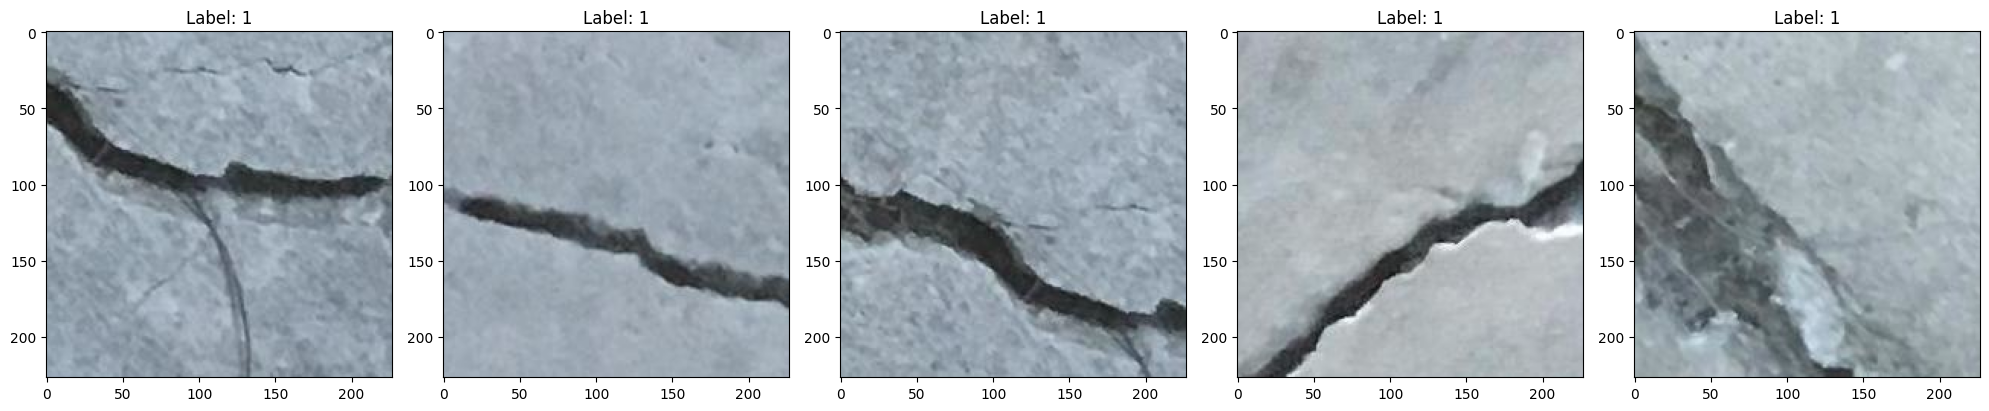

In [13]:
import matplotlib.pyplot as plt

# Plot the images
n_samples_to_show = 5
fig, ax = plt.subplots(nrows=1, ncols=n_samples_to_show, figsize=(20, 5))

for i in range(n_samples_to_show):
    ax[i].imshow(X_train[i], cmap='gray')  # Assuming grayscale images
    ax[i].set_title(f"Label: {y_train[i]}")

plt.tight_layout()
plt.show()

Defining the architecture of the neural network

In [14]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppresses warnings and info messages

from tensorflow import keras
from keras import layers, models


convolutional_base = models.Sequential([
    layers.InputLayer(input_shape=(227, 227, 3), name="convolutional_input"),

    # Block 1
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 2
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 3
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

], name='convolutional_base')

# Sequential layer for data augmentation
data_augmentation = models.Sequential([
    layers.RandomRotation(0.2/(2*np.pi), name="random_rotation"),  # Apply random rotations
    layers.RandomFlip("horizontal_and_vertical", name="random_flip")  # Apply random flipping
], name="data_augmentation")


# Neural Network model
model = models.Sequential([
    layers.InputLayer(input_shape=(227, 227, 3), name="input_layer"),
    data_augmentation,
    layers.Normalization(name='normalization'),
    convolutional_base,
    layers.GlobalMaxPooling2D(name="global_max_pooling2d"), # Add Global Max Pooling layer
    layers.Dropout(0.5, name="dropout"),
    layers.Dense(1, activation="sigmoid", name="dense") # Add Dense layer for binary classification
    
], name='cnn_model')

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 227, 227, 3)      0         
 al)                                                             
                                                                 
 normalization (Normalizatio  (None, 227, 227, 3)      7         
 n)                                                              
                                                                 
 convolutional_base (Sequent  (None, 28, 28, 64)       72080     
 ial)                                                            
                                                                 
 global_max_pooling2d (Globa  (None, 64)               0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0 

Training the network

In [36]:
n_epochs = 30

history = model.fit(
    X_train,
    y_train,  # Input data and labels
    validation_data=(X_val, y_val),  # Validation data
    epochs=n_epochs,  # Adjust the number of epochs based on your needs
    batch_size=32,  # Adjust batch size as needed
    verbose=1  # Show progress during training
)

Epoch 1/30
110/110 [==============================] - 37s 340ms/step - loss: 0.0516 - accuracy: 0.9829 - val_loss: 0.0389 - val_accuracy: 0.9840
Epoch 2/30
110/110 [==============================] - 35s 321ms/step - loss: 0.0516 - accuracy: 0.9829 - val_loss: 0.0559 - val_accuracy: 0.9773
Epoch 3/30
110/110 [==============================] - 36s 324ms/step - loss: 0.0502 - accuracy: 0.9849 - val_loss: 0.0733 - val_accuracy: 0.9840
Epoch 4/30
110/110 [==============================] - 36s 326ms/step - loss: 0.0355 - accuracy: 0.9871 - val_loss: 0.0472 - val_accuracy: 0.9880
Epoch 5/30
110/110 [==============================] - 35s 318ms/step - loss: 0.0411 - accuracy: 0.9871 - val_loss: 0.0393 - val_accuracy: 0.9893
Epoch 6/30
110/110 [==============================] - 821s 8s/step - loss: 0.0649 - accuracy: 0.9791 - val_loss: 0.0674 - val_accuracy: 0.9867
Epoch 7/30
110/110 [==============================] - 34s 313ms/step - loss: 0.0504 - accuracy: 0.9837 - val_loss: 0.0278 - val_accu

Displaying results

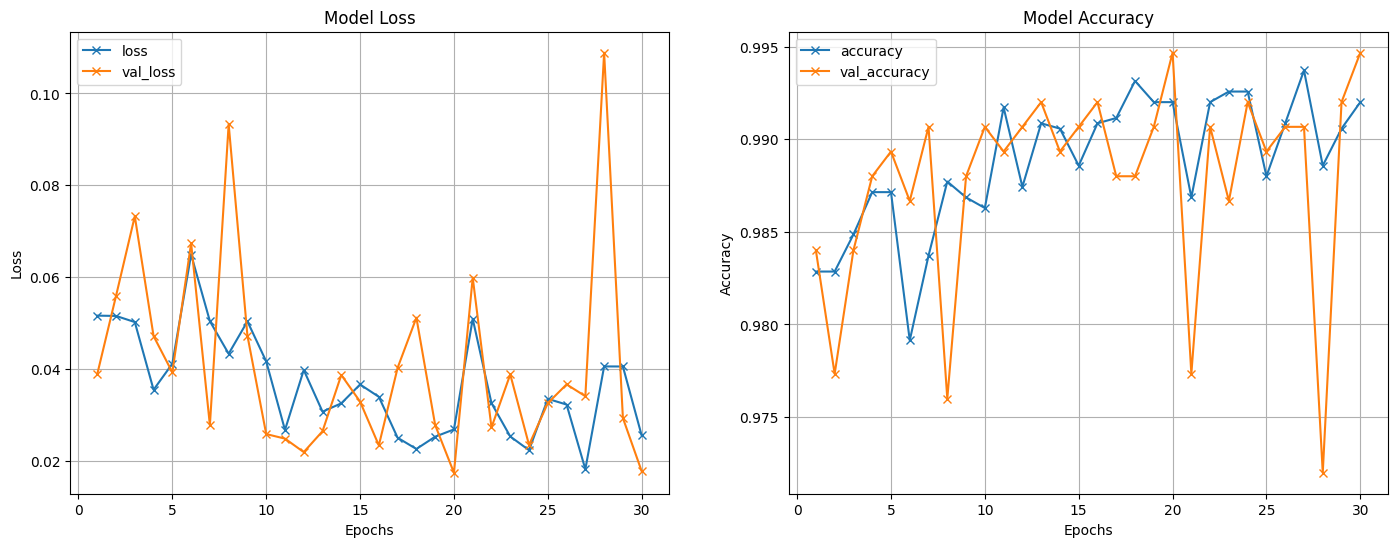

In [37]:
import matplotlib.pyplot as plt

fig, (ax_loss, ax_acc) = plt.subplots(nrows=1, ncols=2, figsize=(17, 6))

epochs = range(1, n_epochs+1)

# Plot for loss
ax_loss.plot(epochs, history.history['loss'], marker='x', label='loss')
ax_loss.plot(epochs, history.history['val_loss'], marker='x', label='val_loss')
ax_loss.grid()
ax_loss.set_title('Model Loss')
ax_loss.set_xlabel('Epochs')
ax_loss.set_ylabel('Loss')
ax_loss.legend()

# Plot for accuracy
ax_acc.plot(epochs, history.history['accuracy'], marker='x', label='accuracy')
ax_acc.plot(epochs, history.history['val_accuracy'], marker='x', label='val_accuracy')
ax_acc.grid()
ax_acc.set_title('Model Accuracy')
ax_acc.set_xlabel('Epochs')
ax_acc.set_ylabel('Accuracy')
ax_acc.legend()

Evaluating performance

In [38]:
from sklearn.metrics import confusion_matrix

# Predict the test set
y_pred = model.predict(X_test) > 0.5
y_pred = y_pred.ravel().astype('int')

# Compute confusion matrix
confusion_matrices = confusion_matrix(y_test, y_pred)
print(confusion_matrices)

# Identify misclassified samples
well_classified_indices = np.where(y_test == y_pred)[0]
print(f"Correctly predicted: {len(well_classified_indices)} out of {len(y_test)}.")

24/24 [==============================] - 1s 26ms/step
[[371   4]
 [  0 375]]
Correctly predicted: 746 out of 750.


Saving the model

In [40]:
import pickle

model.save('models//saved_cnn_model')
        
# Assume `history` is the return value from model.fit()
with open("models/training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)